In [14]:
import polars as pl

In [15]:
lf_business = pl.scan_parquet("./data/business.parquet")
lf_review   = pl.scan_parquet("./data/review.parquet")
lf_tip      = pl.scan_parquet("./data/tip.parquet")
lf_user     = pl.scan_parquet("./data/user.parquet")

In [16]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from wordcloud import WordCloud


OUTPUT_DIR = "./data/outputs_nlp"

CUSTOM_STOPWORDS = {
    "ve", "dont", "didnt", "doesnt", "im", "ive", "youre", "didn", "doesn",
    "cant", "couldnt", "wouldnt", "shouldnt", "wont", "isnt", "arent", "wasnt", "werent",
    "theyre", "weve", "yelp", "gym", "class", "classes"
}

_clean_url = re.compile(r"http\S+|www\.\S+")
_clean_non_letters = re.compile(r"[^a-zA-Z\s']")
_clean_multi_space = re.compile(r"\s+")
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = _clean_url.sub(" ", s)
    s = _clean_non_letters.sub(" ", s)
    s = _clean_multi_space.sub(" ", s).strip()
    return s


In [17]:
reviews_min = (
    lf_review
      .select(["stars", "text"])
      .drop_nulls()
)

bad_texts = (
    reviews_min
      .filter(pl.col("stars").is_in([1, 2]))
      .select(pl.col("text").cast(pl.Utf8))
      .collect()
      .get_column("text")
      .to_list()
)

good_texts = (
    reviews_min
      .filter(pl.col("stars").is_in([4, 5]))
      .select(pl.col("text").cast(pl.Utf8))
      .collect()
      .get_column("text")
      .to_list()
)

len_bad, len_good = len(bad_texts), len(good_texts)
print(f"Total reseñas malas: {len_bad} | Total reseñas buenas: {len_good}")


Total reseñas malas: 1984 | Total reseñas buenas: 3538


Tras limpieza -> malas: 1984 | buenas: 3538
Guardado: ./data/outputs_nlp/wc_bad_all.png


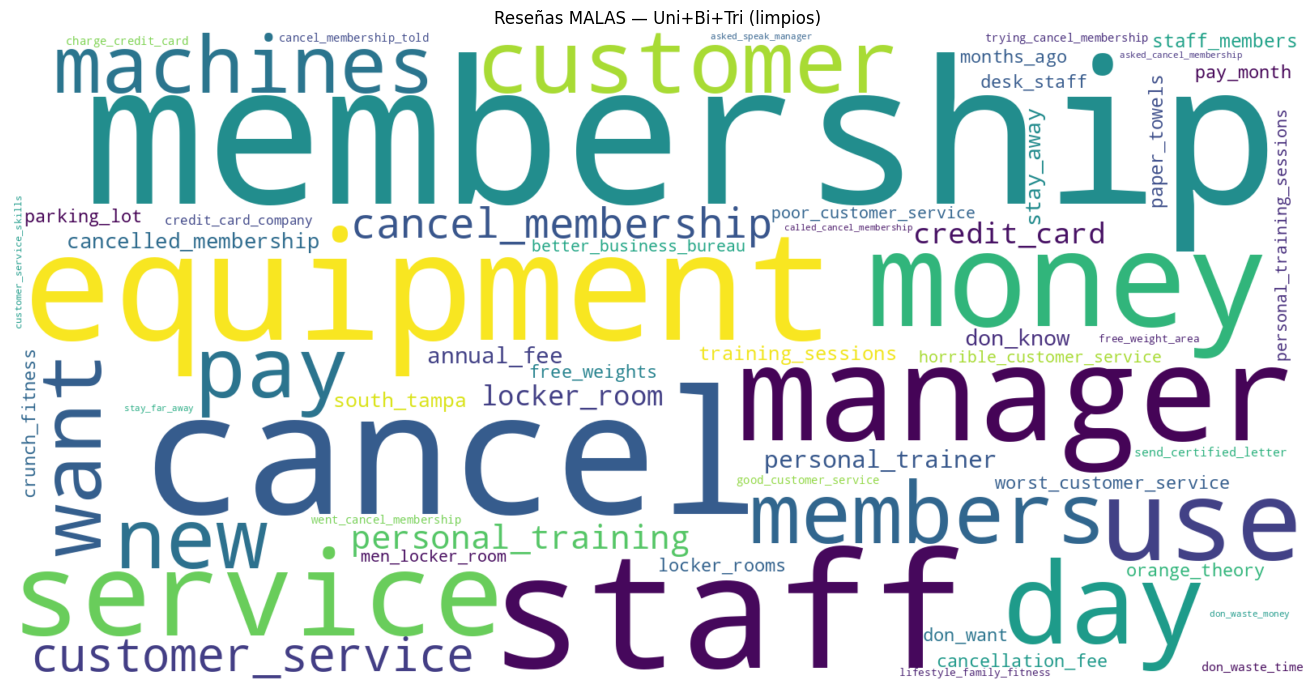

Guardado: ./data/outputs_nlp/wc_good_all.png


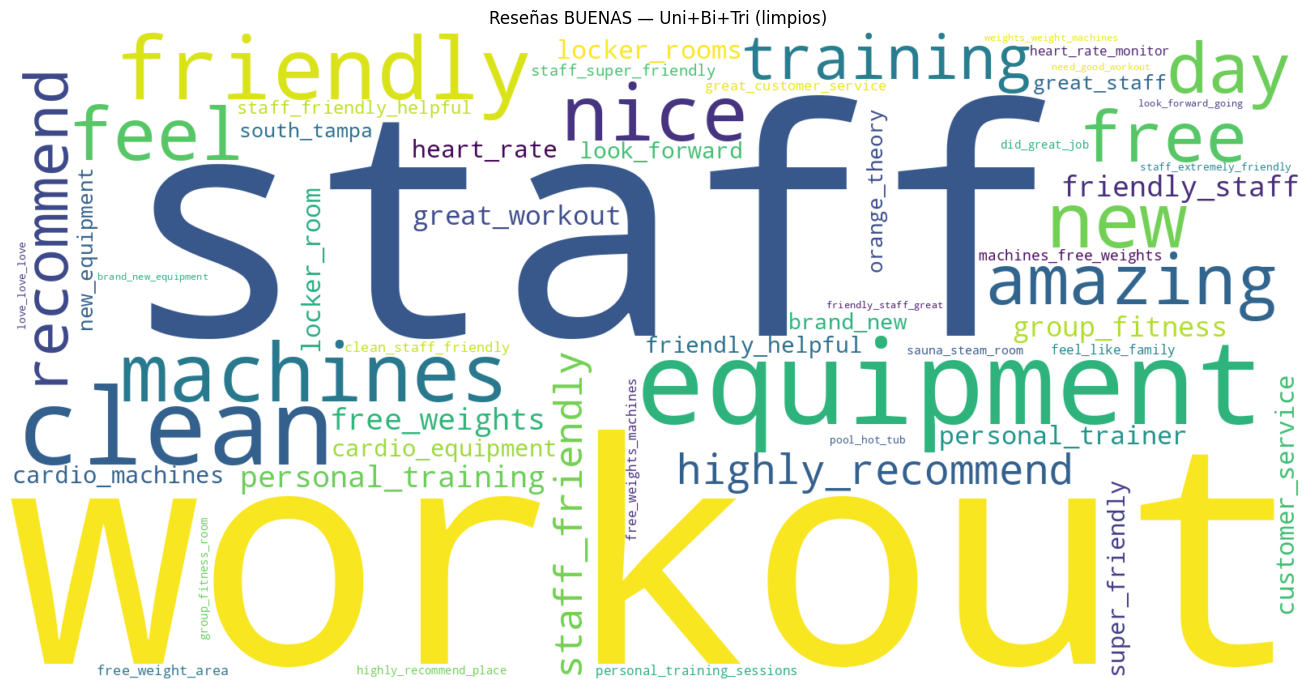

Guardado: ./data/outputs_nlp/wc_bad_uni.png


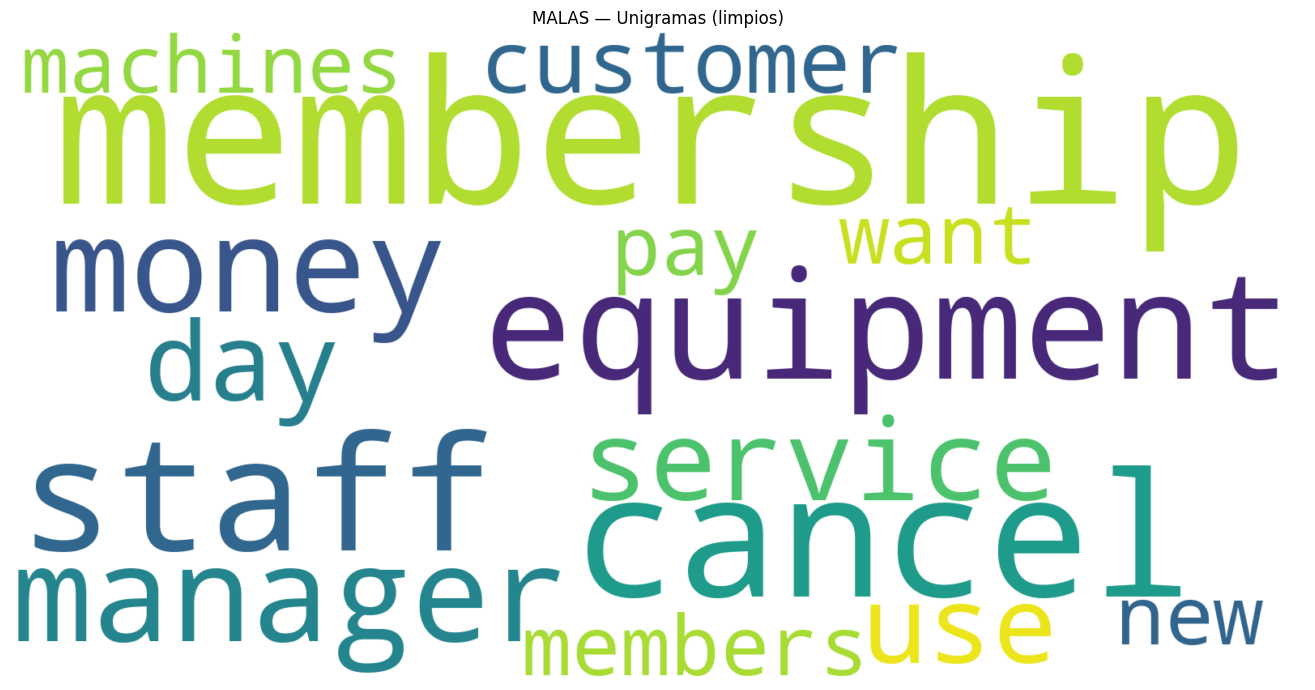

Guardado: ./data/outputs_nlp/wc_bad_bi.png


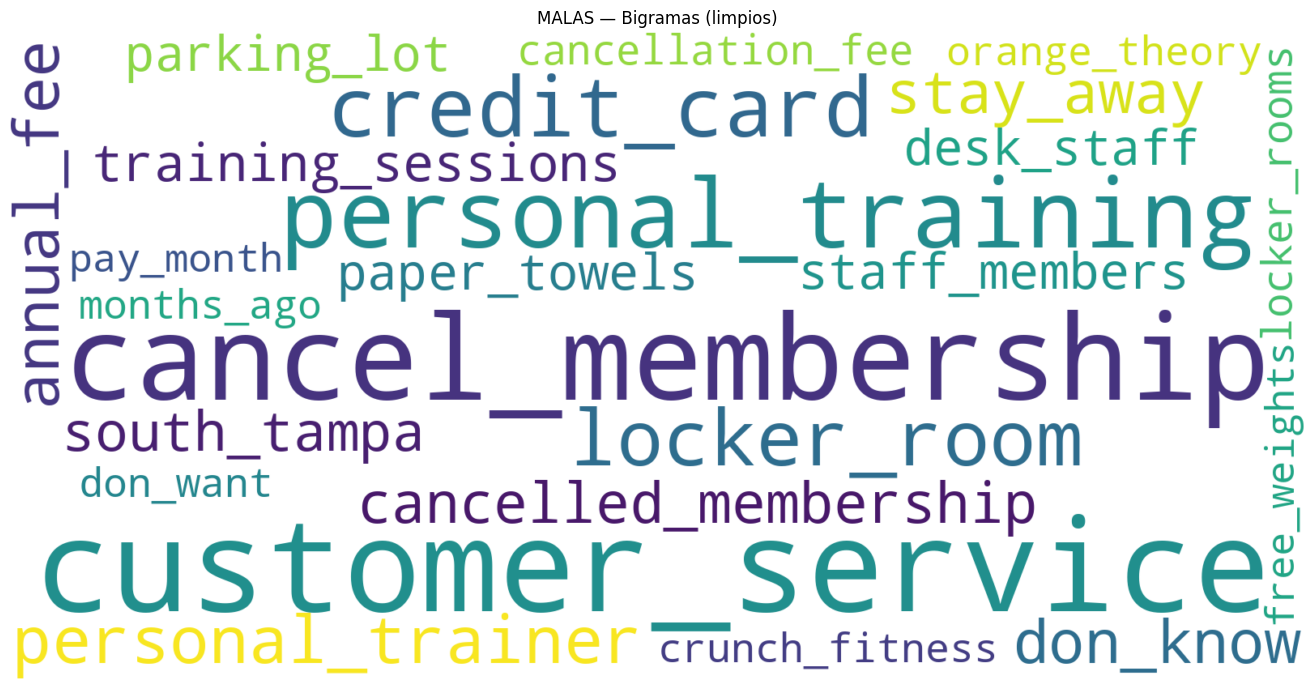

Guardado: ./data/outputs_nlp/wc_bad_tri.png


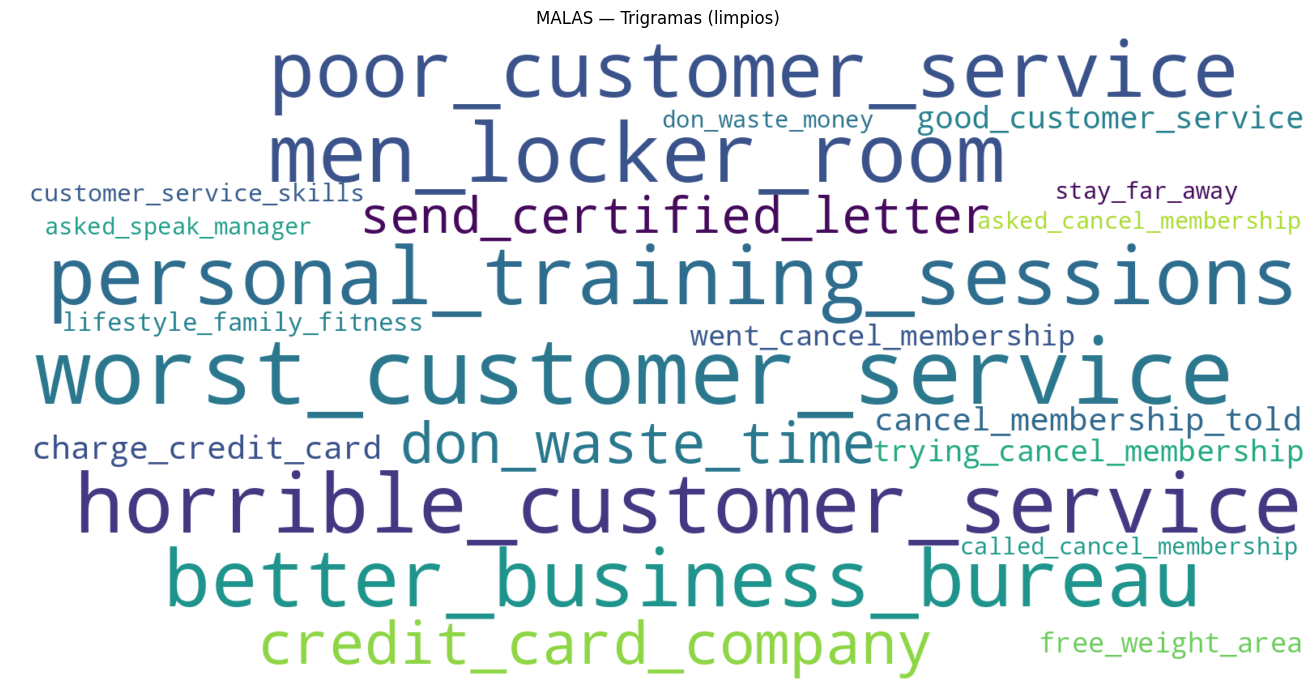

Guardado: ./data/outputs_nlp/wc_good_uni.png


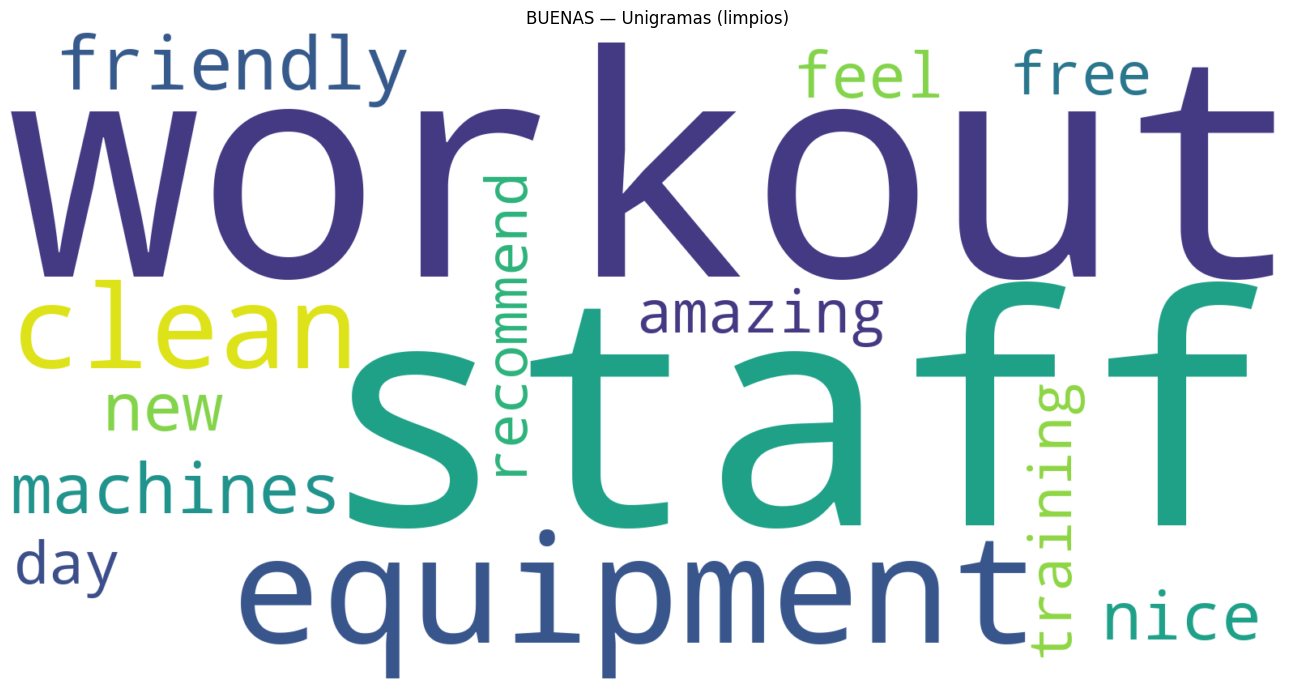

Guardado: ./data/outputs_nlp/wc_good_bi.png


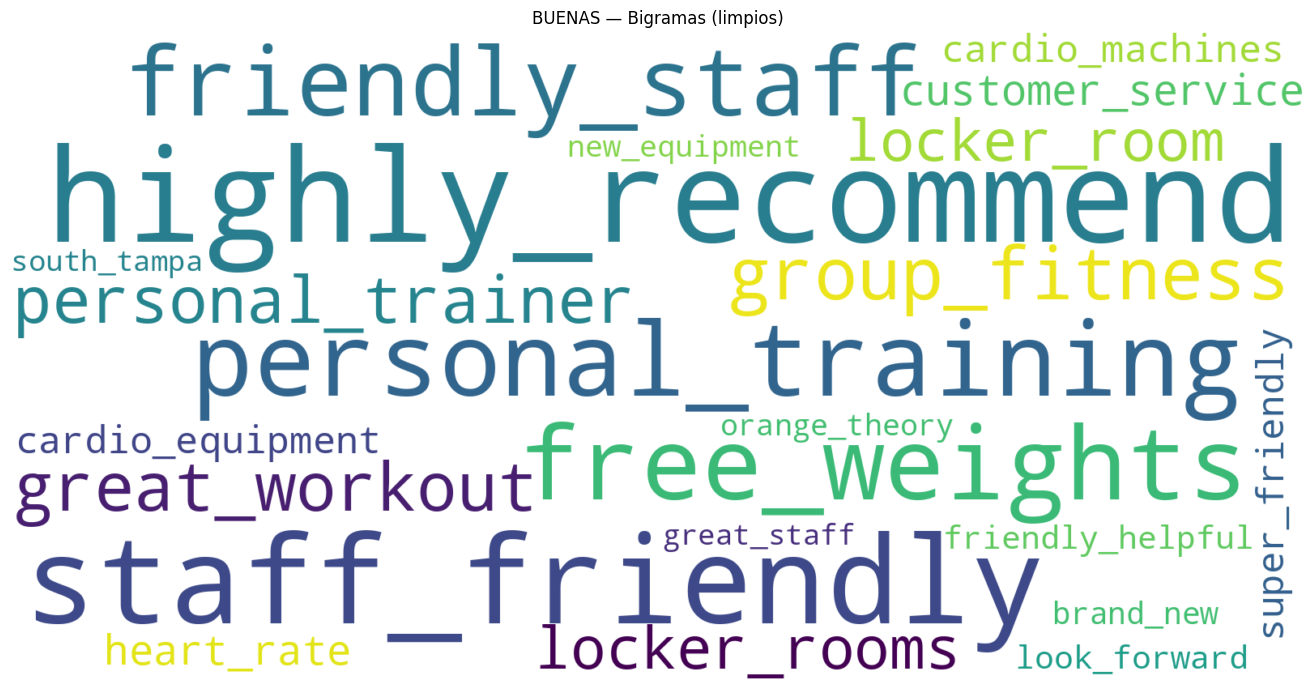

Guardado: ./data/outputs_nlp/wc_good_tri.png


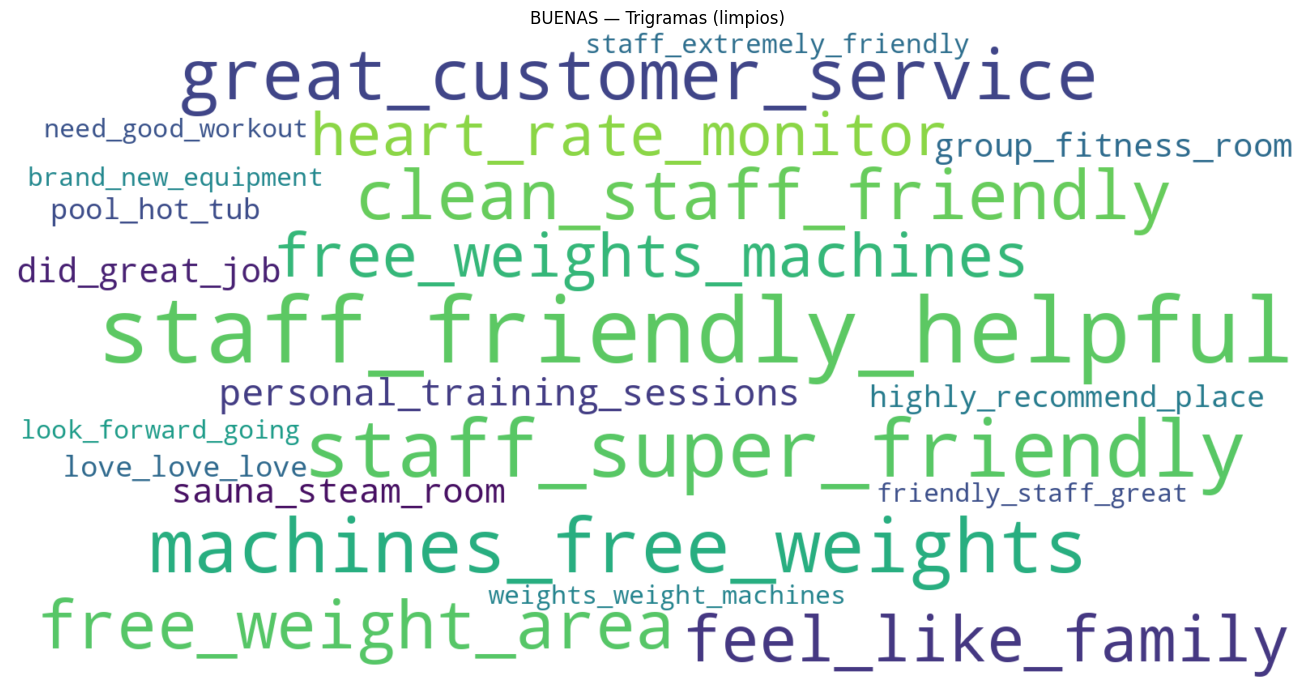

In [19]:

bad_texts_clean  = [normalize_text(t) for t in bad_texts if isinstance(t, str)]
good_texts_clean = [normalize_text(t) for t in good_texts if isinstance(t, str)]

bad_texts_clean  = [t for t in bad_texts_clean  if t]
good_texts_clean = [t for t in good_texts_clean if t]

print(f"Tras limpieza -> malas: {len(bad_texts_clean)} | buenas: {len(good_texts_clean)}")


from sklearn.feature_extraction import text as sklearn_text
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def top_ngrams(
    texts,
    ngram_range=(1,1),
    top_k=30,
    min_df=5,
    max_df=0.9,
    extra_stopwords=None
):
    if not texts:
        return []
    if extra_stopwords is None:
        extra_stopwords = set()
    stop_words = list(sklearn_text.ENGLISH_STOP_WORDS.union(CUSTOM_STOPWORDS).union(extra_stopwords))

    n_docs = len(texts)
    safe_min_df = min_df
    if isinstance(min_df, int) and min_df > n_docs:
        safe_min_df = 1

    vect = CountVectorizer(
        ngram_range=ngram_range,
        stop_words=stop_words,
        min_df=safe_min_df,
        max_df=max_df
    )
    try:
        X = vect.fit_transform(texts)
    except ValueError as e:
        print(f"[Aviso] Vocabulario vacío: {e}")
        return []
    if X.shape[1] == 0:
        return []

    freqs = X.sum(axis=0).A1
    vocab = vect.get_feature_names_out()
    pairs = list(zip(vocab, freqs))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:top_k]


TOP_K   = 30
MIN_DF  = 5
MAX_DF  = 0.9
EXTRA_SW = set()

bad_uni = top_ngrams(bad_texts_clean,  (1,1), top_k=TOP_K, min_df=MIN_DF, max_df=MAX_DF, extra_stopwords=EXTRA_SW)
bad_bi  = top_ngrams(bad_texts_clean,  (2,2), top_k=TOP_K, min_df=MIN_DF, max_df=MAX_DF, extra_stopwords=EXTRA_SW)
bad_tri = top_ngrams(bad_texts_clean,  (3,3), top_k=TOP_K, min_df=MIN_DF, max_df=MAX_DF, extra_stopwords=EXTRA_SW)

good_uni = top_ngrams(good_texts_clean, (1,1), top_k=TOP_K, min_df=MIN_DF, max_df=MAX_DF, extra_stopwords=EXTRA_SW)
good_bi  = top_ngrams(good_texts_clean, (2,2), top_k=TOP_K, min_df=MIN_DF, max_df=MAX_DF, extra_stopwords=EXTRA_SW)
good_tri = top_ngrams(good_texts_clean, (3,3), top_k=TOP_K, min_df=MIN_DF, max_df=MAX_DF, extra_stopwords=EXTRA_SW)



import re

NOISE_UNI = {
    "great","good","best","love","really","just","like",
    "time","people","place","area","location","work","going","said","told","know","don",
    "month","months","member","fitness"
}
NOISE_BI = {
    "la fitness","planet fitness","anytime fitness","great place","st pete","love place",
    "feel like","make sure","member years","month month"
}
NOISE_TRI = {
    "tampa bay area","anytime fitness locations","hyde park location","south tampa location",
    "great place work","great place workout","make feel like","say good things",
    "la fitness locations","member la fitness"
}
NOISE_PATTERNS = [
    re.compile(r"\b.* location\b"),
    re.compile(r"\b(st|saint)\b"),
]

def is_noise(term: str, n: int) -> bool:
    t = term.lower().strip()
    if n == 1 and t in NOISE_UNI: return True
    if n == 2 and t in NOISE_BI:  return True
    if n == 3 and t in NOISE_TRI: return True
    for rx in NOISE_PATTERNS:
        if rx.search(t):
            return True
    return False

def filter_pairs(pairs, n):
    out = []
    for term, freq in pairs:
        if not term:
            continue
        if len(term.split()) != n:
            continue
        if is_noise(term, n):
            continue
        if any(len(tok) <= 2 for tok in term.split()):
            continue
        out.append((term, int(freq)))
    return out

bad_uni_f  = filter_pairs(bad_uni, 1)
bad_bi_f   = filter_pairs(bad_bi,  2)
bad_tri_f  = filter_pairs(bad_tri, 3)

good_uni_f = filter_pairs(good_uni, 1)
good_bi_f  = filter_pairs(good_bi,  2)
good_tri_f = filter_pairs(good_tri, 3)



from wordcloud import WordCloud

import matplotlib.pyplot as plt
from pathlib import Path

WC_DIR = OUTPUT_DIR


def pairs_to_freq(pairs, join_char="_"):
    freqs = {}
    for term, freq in pairs:
        t = str(term).strip().replace(" ", join_char)
        freqs[t] = freqs.get(t, 0) + int(freq)
    return freqs

def merge_freqs(*weighted_pairs, join_char="_"):
    freqs = {}
    for pairs, w in weighted_pairs:
        for term, freq in pairs:
            t = str(term).strip().replace(" ", join_char)
            val = int(freq) * float(w)
            freqs[t] = freqs.get(t, 0.0) + val
    return freqs

def plot_wc(freqs, title, filename=None, width=1600, height=800):
    if not freqs:
        print(f"[WordCloud] Sin datos: {title}")
        return
    wc = WordCloud(
        width=width, height=height, background_color="white",
        collocations=False, normalize_plurals=False
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    if filename:
        out = WC_DIR + '/' + filename
        wc.to_file(str(out))
        print("Guardado:", out)
    plt.show()

TOP_N_CLOUD = 200
def top_n_freq(d, n=200):
    return dict(sorted(d.items(), key=lambda kv: kv[1], reverse=True)[:n])

bad_all_freq  = merge_freqs((bad_uni_f, 1.0), (bad_bi_f, 1.25), (bad_tri_f, 1.5))
good_all_freq = merge_freqs((good_uni_f, 1.0), (good_bi_f, 1.25), (good_tri_f, 1.5))

plot_wc(top_n_freq(bad_all_freq,  TOP_N_CLOUD),  "Reseñas MALAS — Uni+Bi+Tri (limpios)",  "wc_bad_all.png")
plot_wc(top_n_freq(good_all_freq, TOP_N_CLOUD), "Reseñas BUENAS — Uni+Bi+Tri (limpios)", "wc_good_all.png")

plot_wc(pairs_to_freq(bad_uni_f),  "MALAS — Unigramas (limpios)",  "wc_bad_uni.png")
plot_wc(pairs_to_freq(bad_bi_f),   "MALAS — Bigramas (limpios)",   "wc_bad_bi.png")
plot_wc(pairs_to_freq(bad_tri_f),  "MALAS — Trigramas (limpios)",  "wc_bad_tri.png")

plot_wc(pairs_to_freq(good_uni_f), "BUENAS — Unigramas (limpios)", "wc_good_uni.png")
plot_wc(pairs_to_freq(good_bi_f),  "BUENAS — Bigramas (limpios)",  "wc_good_bi.png")
plot_wc(pairs_to_freq(good_tri_f), "BUENAS — Trigramas (limpios)", "wc_good_tri.png")
